# IFAC 2024 : Unsupervised features

## Libraries
We start by importing the necessary libraries for data processing, visualization, and feature extraction.

In [7]:
import scipy.io
import matplotlib.pyplot as plt
import neurokit2 as nk
import pandas as pd
import os
import numpy as np
from utility import time_hour, find_first


## Load and pre-process signals
We load the target data and the corrected markers, then process each file to segment the signals based on the markers.

In [8]:
# Load the target data
target = pd.read_csv("DATA_PASS.csv")
target = target.dropna()
target['CONDITION'].replace(['TF1', 'TF2', 'TF3', 'OUT4', 'OUT5', 'OUT6'], [11, 12, 13, 14, 15, 16], inplace=True)

# Get unique participant numbers
part = target["Participant Number"].unique()

# Load corrected markers
markers_corrected = pd.read_csv("correctedMarkers.csv")
part_un = markers_corrected["Participant"].unique()

# Find common participants
part_markcorr = np.intersect1d(part, part_un)

# Initialize dictionary to store signals for each participant
part_signals = {}

# Process each file
files = os.listdir("PASS_BH3/")
for f in files:
    participant_number = int(f[:4])
    if participant_number in part_markcorr:
        # Load signal
        signal = scipy.io.loadmat(f"PASS_BH3/{f}")['data_eeg']
        sig_fil = nk.ecg_clean(signal, sampling_rate=250, method='vg')

        # Load timestamps
        time = scipy.io.loadmat(f"PASS_BH3_metdat/{f[:4]}_time{f[4:]}")['data_markers']
        timestamps = list(time[:])
        time_vct = time_hour(timestamps)

        # Get corrected markers
        time_p = markers_corrected.loc[markers_corrected['Participant'] == participant_number, 'timestamp'].values
        status_p = markers_corrected.loc[markers_corrected['Participant'] == participant_number, 'Status'].values

        # Find first occurrences of timestamps
        first_occ = find_first(time_vct, time_p)

        # Segment the signals based on markers
        segments = {}
        for start, end, status in zip(first_occ[:-1], first_occ[1:], status_p):
            segment = sig_fil[start:end]
            if status not in segments:
                segments[status] = []
            segments[status].append(segment)

        # Store segments for the participant
        part_signals[f[:6]] = segments

/var/folders/gl/css3yr3559x6r9nrv6z186zm0000gn/T/ipykernel_97300/3040076618.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  target['CONDITION'].replace(['TF1', 'TF2', 'TF3', 'OUT4', 'OUT5', 'OUT6'], [11, 12, 13, 14, 15, 16], inplace=True)
/var/folders/gl/css3yr3559x6r9nrv6z186zm0000gn/T/ipykernel_97300/3040076618.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future

## Save the segmented signals
We save the segmented signals to a file called `ecg_signals.npy`.

In [9]:
# Save the segmented signals
np.save("../Data/ecg_signals.npy", part_signals)

## Visualization
We plot an example of the first segmented signal for visualization purposes.

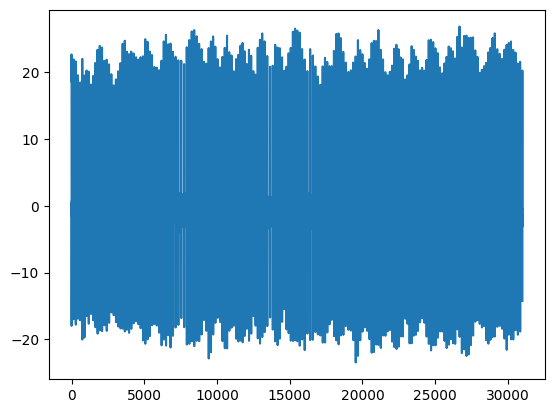

In [10]:
# Example plot of the first segmented signal
plt.plot(part_signals[list(part_signals.keys())[0]][list(part_signals[list(part_signals.keys())[0]].keys())[0]][0])
plt.show()